# titanic-scorecard

For this project, we will follow the Data Science Processes, use the Cross Industry Process for Data Mining(CRISP-DM) method.

This method has a 6-step approach:

1. Business understanding
2. Data understanding
3. Prepare data
4. Data Modelling
5. Evaluate the Result
6. Deploy

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# for missing value visualisation
import missingno as msno

# regular expression for text processing
import re

## 1. Business Understanding

Inspiration

This dataset is from the legendary Kaggle competition, "Titanic: Machine Learning from Disaster" https://www.kaggle.com/c/titanic.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

We will approach this competition from a totally different perspective: what if the accuracy is not the primary goal, instead, the model has to be able to be implemented within a simple system? 

The objective for this project is to produce a model that is easy to understand, easy to interpret and easy to implement (yet, perform reasonably well).

I will borrow ideas from credit risk scorecard modelling in the credit rating industry, add a few more recent approaches and see if this modelling method can give us a good enough performance.

Reference
Intelligent Credit Scoring(2nd Ed), Naeem Siddiqi (2017)

About the data

In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

The end product of the model will be as a form of scorecard, where each feature will be broken down to discrete intervals and each interval will be given a score. We will sum the scores for each observation and transform the scores into probability of survival.

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
submission = pd.read_csv('test.csv')
submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The submission data comes with the same features, except the Survived column.

For this project, we will not classify the submission table using python, so we will not be referencing the submission dataset often.

## 2. Data Understanding(Exploratory Data Analysis)

### Data Type

In [4]:
# Inspect the data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# Inspect the dimension

df.shape

print("There are {} observations and {} features".format(df.shape[0], df.shape[1]))

There are 891 observations and 12 features


In [6]:
# separate categorical and numerical features

categorical = [var for var in df.columns if df[var].dtype=='O']
numerical = [var for var in df.columns if df[var].dtype!='O']

print("There are {} categorical variables and {} numerical variables.".format(len(categorical),len(numerical)))

There are 5 categorical variables and 7 numerical variables.


In [7]:
# view of categorical variables

df[categorical].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [8]:
# view of numerical variables

df[numerical].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [9]:
for var in categorical + numerical:
    print(var, 'has', len(df[var].unique()), 'unique values.')

Name has 891 unique values.
Sex has 2 unique values.
Ticket has 681 unique values.
Cabin has 148 unique values.
Embarked has 4 unique values.
PassengerId has 891 unique values.
Survived has 2 unique values.
Pclass has 3 unique values.
Age has 89 unique values.
SibSp has 7 unique values.
Parch has 7 unique values.
Fare has 248 unique values.


Observation:
* 3 Discrete Variables: Pclass
* 2 Continuous Variables: Fare, Age, SibSp, Parch
* 1 Meta Value: PassengerId
* 1 Boolean: Survived (target)

### Missing Values

In typical machine learning projects, we need to first examine the missingness of the data.

Based on the percentage and nature of the missingness, such as Missing Completely at Random(MAR), Missing at Random(MAR), Missing not at Random(MNAR), we will take actions(drop feature, impute missing value) accordingly.

In typical scorecard projects, we do not have to worry about the missing values, because we will eventually convert all the features into discrete categorical variables, all missing values can be treated as a separte category.(Same goes for outliers) 

In this project, we will use the latter method. This will enable an easier deployment, because imputation method can be tricky in Excel.

During the modelling stage, we will use arbituary value method, ie. impute missing value with -99 for numerical features, and 'missing' for categorical features

#### Explore Missingness

In [10]:
# print variables with missing data in training data
for col in numerical + categorical:
    if df[col].isnull().mean()>0:
        print(col, "has",df[col].isnull().sum(),'missing values, which is', round(df[col].isnull().mean()*100,2),'%.')

Age has 177 missing values, which is 19.87 %.
Cabin has 687 missing values, which is 77.1 %.
Embarked has 2 missing values, which is 0.22 %.


In [11]:
# print variables with missing data in submission data
for col in list(filter(lambda var: var != 'Survived', numerical + categorical)):
    if submission[col].isnull().mean()>0:
        print(col, "has",submission[col].isnull().sum(),'missing values, which is', round(submission[col].isnull().mean()*100,2),'%.')

Age has 86 missing values, which is 20.57 %.
Fare has 1 missing values, which is 0.24 %.
Cabin has 327 missing values, which is 78.23 %.


Feature 'Embarked' only has missing value in training data

Feature 'Fare' only has missing value in submission data

#### Visualise Missingness

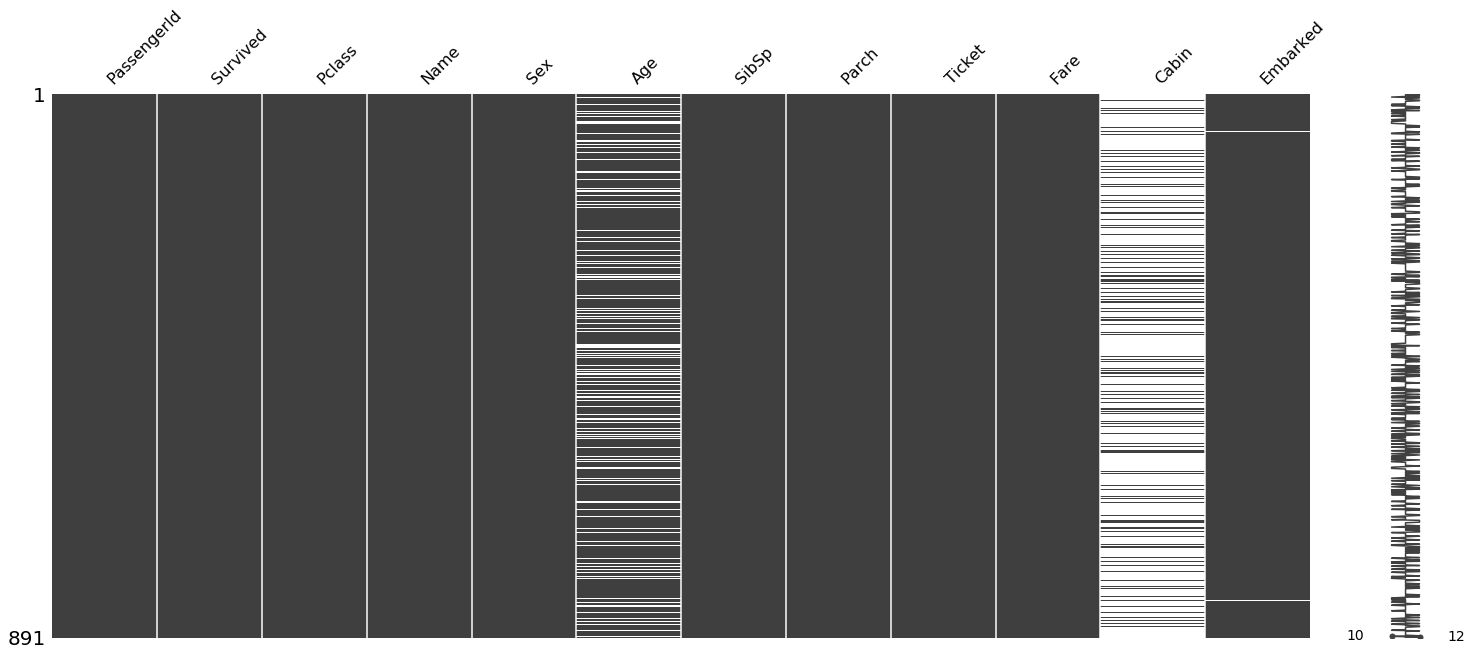

In [12]:
msno.matrix(df);

Now let's check if the missingness is correlated

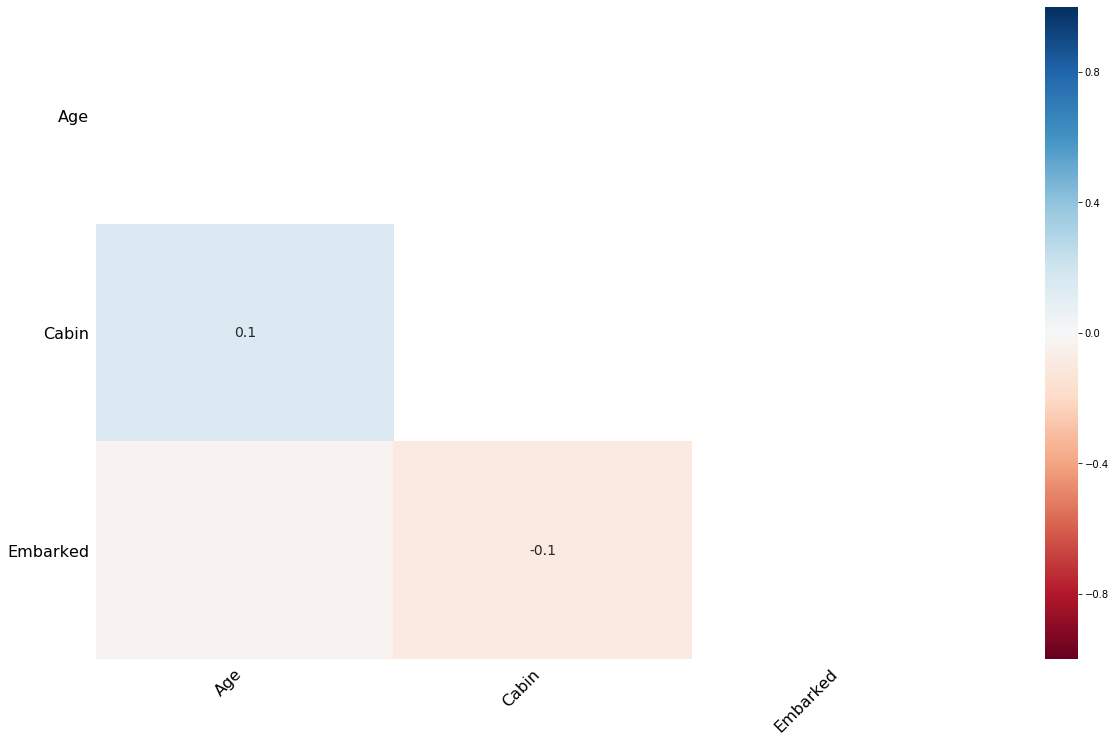

In [13]:
msno.heatmap(df);

Observation:
* The missingness in different features does not correlate one another
* Impute age with -99 to indicate missing
* Impute missing to Cabin(after feature transformation)
* Impute submission dataset 'Fare' with median fare from training set

## 3. Data Preparation

#### Cardinality: Number of Labels


_**Name has 891 unique values.**_

Sex has 2 unique values.

_**Ticket has 681 unique values.**_

_**Cabin has 148 unique values.**_

Embarked has 4 unique values.

PassengerId has 891 unique values.

Survived has 2 unique values.

Pclass has 3 unique values.

Age has 89 unique values.

SibSp has 7 unique values.

Parch has 7 unique values.

Fare has 248 unique values.

##### Name

In [14]:
def get_title(passenger):
    # extracts the title from the name variable
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

In [15]:
# apply the function to create a Title column
df['Title'] = df['Name'].apply(get_title)
submission['Title'] = submission['Name'].apply(get_title)

df[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [16]:
# drop the name column
df.drop(labels='Name', inplace=True, axis=1)

##### Cabin

Note the first string is a letter, follows by a numerical value, separate them

In [17]:
# Cabin
df['Cabin_numerical'] = df.Cabin.str.extract('(\d+)') # extracts number from string
df['Cabin_numerical'] = df['Cabin_numerical'].astype('float') # parses the above variable to float type

df['Cabin_categorical'] = df['Cabin'].str[0] # captures first letter of string (the letter of the cabin)

df[['Cabin', 'Cabin_numerical', 'Cabin_categorical']].head()

,Cabin,Cabin_numerical,Cabin_categorical
0,NaN,NaN,NaN
1,C85,85.0,C
2,NaN,NaN,NaN
3,C123,123.0,C
4,NaN,NaN,NaN


In [18]:
# drop the Cabin variable
df.drop(labels='Cabin', inplace=True, axis=1)

##### Ticket
Similar to Cabin, we will separte into numerical and categorical value

In [19]:
# extract the last bit of ticket as number
df['Ticket_numerical'] = df.Ticket.apply(lambda s: s.split()[-1])
df['Ticket_numerical'] = np.where(df.Ticket_numerical.str.isdigit(), df.Ticket_numerical, np.nan)
df['Ticket_numerical'] = df['Ticket_numerical'].astype('float')

# extract the first part of ticket as category
df['Ticket_categorical'] = df.Ticket.apply(lambda s: s.split()[0])
df['Ticket_categorical'] = np.where(df.Ticket_categorical.str.isdigit(), np.nan, df.Ticket_categorical)

df[['Ticket', 'Ticket_numerical', 'Ticket_categorical']].head()

,Ticket,Ticket_numerical,Ticket_categorical
0,A/5 21171,21171.0,A/5
1,PC 17599,17599.0,PC
2,STON/O2. 3101282,3101282.0,STON/O2.
3,113803,113803.0,NaN
4,373450,373450.0,NaN


In [20]:
# Explore the ticket categorical part a bit further
df.Ticket_categorical.unique()

array(['A/5', 'PC', 'STON/O2.', nan, 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'LINE', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

In [21]:
# remove non letter characters from string
ticket_text = df.Ticket_categorical.apply(lambda x: re.sub("[^a-zA-Z]", '', str(x)))

# to visualise the output and compare with input
pd.concat([ticket_text, df.Ticket_categorical], axis=1)

,Ticket_categorical,Ticket_categorical
0,A,A/5
1,PC,PC
2,STONO,STON/O2.
3,nan,NaN
4,nan,NaN
...,...,...
886,nan,NaN
887,nan,NaN
888,WC,W./C.
889,nan,NaN


In [22]:
# set to upper case: we reduce the number of labels quite a bit
ticket_text = ticket_text.str.upper()
ticket_text.unique()

array(['A', 'PC', 'STONO', 'NAN', 'PP', 'CA', 'SCPARIS', 'SCA', 'SP',
       'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SOP', 'FA', 'LINE', 'FCC',
       'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SOPP', 'FC', 'SOTONO',
       'CASOTON'], dtype=object)

In [23]:
# Pass the processed text to categorical column
df['Ticket_categorical'] = ticket_text

In [24]:
# drop the ticket variable
df.drop(labels='Ticket', inplace=True, axis=1)

##### Create new variable Family_size

In [25]:
df['Family_size'] = df['SibSp']+df['Parch']+1 #Including the passenger

In [26]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Family_size
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,NaN,NaN,21171.0,A,2
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,85.0,C,17599.0,PC,2
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,NaN,NaN,3101282.0,STONO,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,123.0,C,113803.0,NAN,2
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,NaN,NaN,373450.0,NAN,1


##### Missing value imputation

In [27]:
# separate categorical and numerical features

categorical_fe = [var for var in df.columns if df[var].dtype=='O']
numerical_fe = [var for var in df.columns if df[var].dtype!='O']

print("There are {} categorical variables and {} numerical variables.".format(len(categorical_fe),len(numerical_fe)))

There are 5 categorical variables and 10 numerical variables.


In [28]:
# print variables with missing data in training data
for col in numerical_fe + categorical_fe:
    if df[col].isnull().mean()>0:
        print(col, "has",df[col].isnull().sum(),'missing values, which is', round(df[col].isnull().mean()*100,2),'%.')

Age has 177 missing values, which is 19.87 %.
Cabin_numerical has 691 missing values, which is 77.55 %.
Ticket_numerical has 4 missing values, which is 0.45 %.
Embarked has 2 missing values, which is 0.22 %.
Cabin_categorical has 687 missing values, which is 77.1 %.


In [29]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_numerical,Ticket_numerical,Family_size
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,200.00000,8.870000e+02,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,50.49000,2.983284e+05,1.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,35.39497,6.576144e+05,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,2.00000,3.000000e+00,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,22.00000,1.487900e+04,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,43.00000,1.122770e+05,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,77.25000,3.470820e+05,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,148.00000,3.101317e+06,11.000000


For Age, Cabin_numerical and Ticket_numerical, we will impute with -99

For Embarked, we will impute with the mode (very few missing value with no missing value in production)

For Cabin_categorical, we will impute the category "missing"

In [30]:
#define a function to fill the missing value

def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [31]:
print("The mode for Embarked is {}".format(df.Embarked.mode().iloc[0]))

The mode for Embarked is S


In [32]:
df['Age_impute'] = impute_na(df, 'Age', -99)
df['Cabin_numerical_impute'] = impute_na(df, 'Cabin_numerical', -99)
df['Ticket_numerical_impute'] = impute_na(df, 'Ticket_numerical', -99)

df['Embarked_impute'] = impute_na(df, 'Embarked', 'S')

df['Cabin_categorical_impute'] = impute_na(df, 'Cabin_categorical', 'missing')

In [33]:
# drop the original variables
df.drop(['Age', 'Cabin_numerical', 'Ticket_numerical', 'Embarked', 'Cabin_categorical'], inplace=True, axis=1)

In [34]:
df.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Title,Ticket_categorical,Family_size,Age_impute,Cabin_numerical_impute,Ticket_numerical_impute,Embarked_impute,Cabin_categorical_impute
0,1,0,3,male,1,0,7.2500,Mr,A,2,22.0,-99.0,21171.0,S,missing
1,2,1,1,female,1,0,71.2833,Mrs,PC,2,38.0,85.0,17599.0,C,C
2,3,1,3,female,0,0,7.9250,Miss,STONO,1,26.0,-99.0,3101282.0,S,missing
3,4,1,1,female,1,0,53.1000,Mrs,NAN,2,35.0,123.0,113803.0,S,C
4,5,0,3,male,0,0,8.0500,Mr,NAN,1,35.0,-99.0,373450.0,S,missing


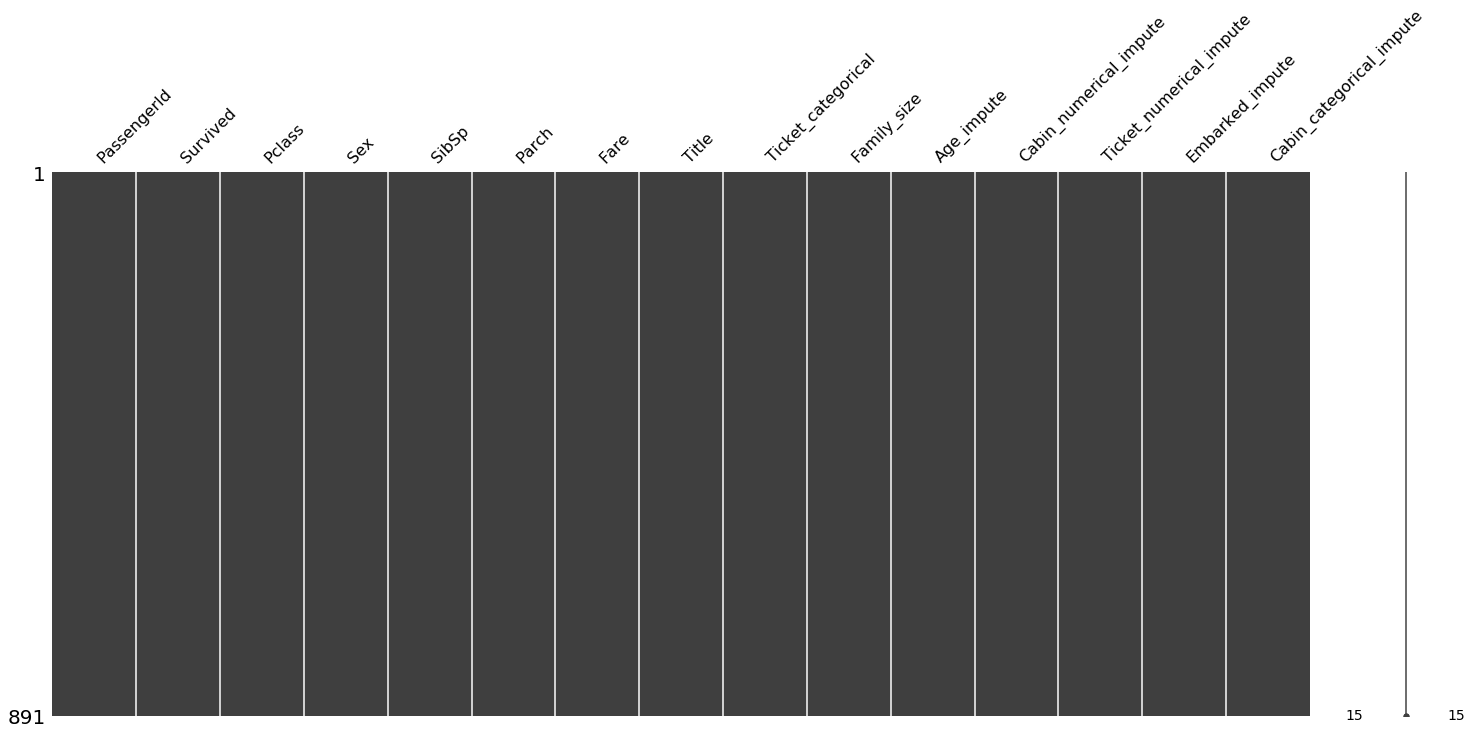

In [35]:
msno.matrix(df);